In [61]:
import sys

sys.path.append("../src")

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.integrate import quad
from scipy.optimize import minimize
import sto_ng
import gaussian_overlap_function
import h5py

importlib.reload(sto_ng)
importlib.reload(gaussian_overlap_function)
from sto_ng import *
from gaussian_overlap_function import *

In [63]:
with h5py.File("sto_ng.h5", "r") as f:
    optimized_params_1s = f["1s/sto-3g/optimized_params"][:]
    optimized_params_2s2p = f["2s2p/sto-2g/optimized_params"][:]

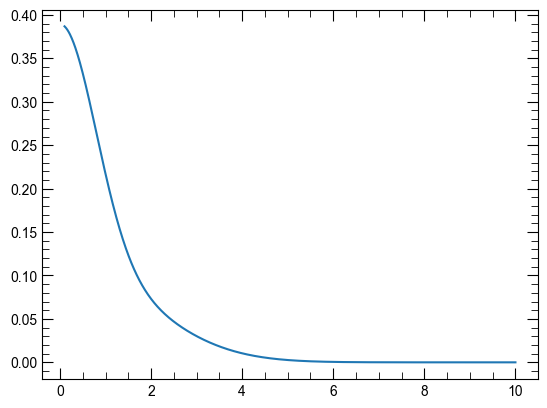

In [64]:
approximator = GaussianApproximator1s(optimized_params_1s, 1.0)
r = np.linspace(0.1, 10, 1000)
y = approximator.phi_approx_g1s(optimized_params_1s, r)
fig, ax = plt.subplots()
ax.plot(r, y)

In [65]:
RA = np.ndarray([0, 0, 0])
RB = np.ndarray([0, 0, 0])
RC = np.ndarray([0, 0, 0])
RD = np.ndarray([0, 0, 0])

In [66]:
def energy_1e(scale):
    result = 0
    for i in range(3):
        for j in range(3):
            alpha = optimized_params_1s[2 * i] * scale**2
            beta = optimized_params_1s[2 * j] * scale**2
            c_i = optimized_params_1s[2 * i + 1]
            c_j = optimized_params_1s[2 * j + 1]
            Salpha = GaussianOverlapFunction.S(alpha, alpha, RA, RC)
            Sbeta = GaussianOverlapFunction.S(beta, beta, RB, RD)
            result += (
                c_i
                * c_j
                * (
                    GaussianOverlapFunction.T(alpha, beta, RA, RB)
                    + 2 * GaussianOverlapFunction.V(alpha, beta, RA, RB, RC)
                )
            ) / np.sqrt(Salpha * Sbeta)
    return 2 * result


def energy_2e(scale):
    result = 0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    alpha = optimized_params_1s[2 * i] * scale**2
                    beta = optimized_params_1s[2 * j] * scale**2
                    gamma = optimized_params_1s[2 * k] * scale**2
                    delta = optimized_params_1s[2 * l] * scale**2
                    c_i = optimized_params_1s[2 * i + 1]
                    c_j = optimized_params_1s[2 * j + 1]
                    c_k = optimized_params_1s[2 * k + 1]
                    c_l = optimized_params_1s[2 * l + 1]
                    Salpha = GaussianOverlapFunction.S(alpha, alpha, RA, RC)
                    Sbeta = GaussianOverlapFunction.S(beta, beta, RB, RD)
                    Sgamma = GaussianOverlapFunction.S(gamma, gamma, RA, RC)
                    Sdelta = GaussianOverlapFunction.S(delta, delta, RB, RD)
                    result += (
                        c_i
                        * c_j
                        * c_k
                        * c_l
                        * (
                            GaussianOverlapFunction.U(
                                alpha, beta, gamma, delta, RA, RB, RC, RD
                            )
                        )
                    ) / np.sqrt(Salpha * Sbeta * Sgamma * Sdelta)
    return result


def total_energy(scale):
    return energy_1e(scale) + energy_2e(scale)

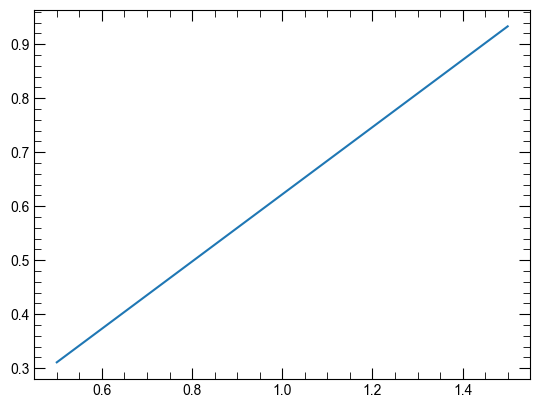

In [67]:
scales = np.linspace(0.5, 1.5, 100)
energies = np.array([energy_2e(scale) for scale in scales])
plt.plot(scales, energies)

In [68]:
energy_2e(0.1)

0.06220338009848203

In [69]:
result = minimize(total_energy, 1.0)
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.7022198143357263
        x: [ 1.681e+00]
      nit: 2
      jac: [ 2.980e-08]
 hess_inv: [[ 5.231e-01]]
     nfev: 6
     njev: 3

In [70]:
result.x

array([1.68135107])

In [71]:
optimized_params_1s

array([8.51761539e-01, 4.30165617e-01, 2.16840434e-19, 4.21840235e-01,
       1.51610304e-01, 6.78882237e-01])

In [72]:
results = []
scales = np.linspace(0.0, 1.5, 100)
for scale in scales:
    results.append(total_energy(scale))

/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  2
/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:47: RuntimeWarning: invalid value encountered in scalar divide
  -alpha * gamma * np.linalg.norm(RA - RC) ** 2 / (alpha + gamma)
/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:48: RuntimeWarning: invalid value encountered in scalar divide
  - beta * delta * np.linalg.norm(RB - RD) ** 2 / (beta + delta)
/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:51: RuntimeWarning: invalid value encountered in scalar divide
  (alpha + gamma)


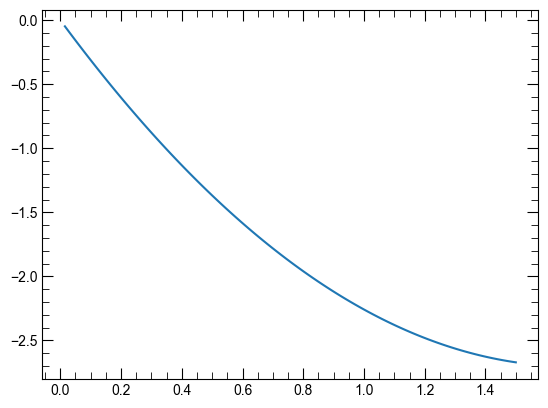

In [73]:
fig, ax = plt.subplots()
ax.plot(scales, results)

In [74]:
optimized_params_1s[0] * optimized_params_1s[1]

0.3663985280399792

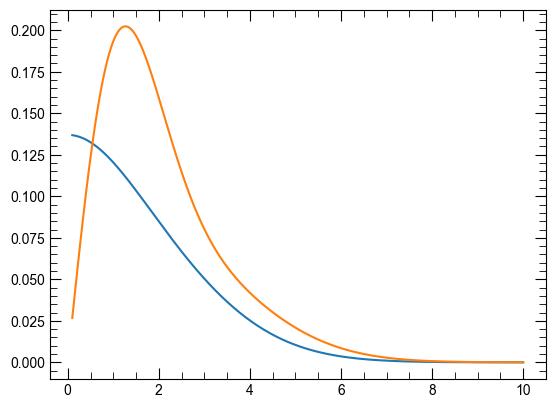

In [75]:
approximator = GaussianApproximator2s2p(optimized_params_2s2p, 1.0)
r = np.linspace(0.1, 10, 1000)
y2s = approximator.phi_approx_g1s(optimized_params_2s2p, r)
y2p = approximator.phi_approx_g2p(optimized_params_2s2p, r)
fig, ax = plt.subplots()
ax.plot(r, y2s)
ax.plot(r, y2p)